<h1> CNN Using Tensor Flow </h1>

<h3> By: Ryan Moore </h3>

<H1> Introduction </H1>

The objective of this analysis is to build a neural network that is capable of identifying handwritten digits.  The model is trained and tested on a a dataset in TensorFlow that contains images of handwritten digits call MNIST dataset. 

In [82]:
import tensorflow as tf
import seaborn as sns
import keras
import numpy as np 
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

<H1> Analysis </H1>

In [83]:
#Load the dataset
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

<h3> Data </h3>

In [84]:
#Print the number of training examples
print(f"Number of training examples: {ds_info.splits['train'].num_examples}")

# Print the number of test examples
print(f"Number of test examples: {ds_info.splits['test'].num_examples}")

# Print the feature names and their properties
print("Features:")
print(ds_info.features)

Number of training examples: 60000
Number of test examples: 10000
Features:
FeaturesDict({
    'image': Image(shape=(28, 28, 1), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})


The dataset contains 70,000 images. 
The images are 28 pixels by 28 pixels and have one color.
The images are stored as unsigned 8-bit integers. 
The labels are stored as 64-bit integers.
There are 10 distinct classes in the dataset which correspond to the digits 0 through 9. 

<h3> Exploratory Data Analysis </h3>

2025-09-16 19:31:34.378604: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-09-16 19:31:34.379497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


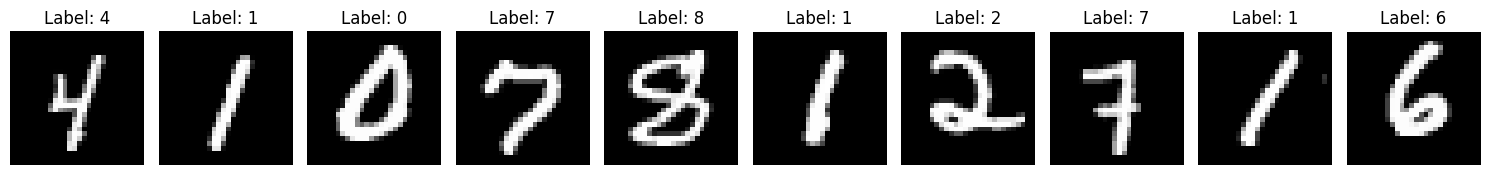

In [85]:
#Visualize the first 10 images to see the dataset
items_to_plot = list(ds_train.take(10))

# Create the figure and axes objects
fig, axes = plt.subplots(1, 10, figsize=(15, 2))

#For loop to covert into Numpy Arrays for plotting
for i, (image, label) in enumerate(items_to_plot):
    image = image.numpy()
    label = label.numpy()
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()




Images are handwritten digits that are a bit blurry and low resolution. 

The images are in a black box and written with white ink. 

The handwriting has different styles such as the 7. One has a line through it while the other does not. 

2025-09-16 19:31:44.884168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-09-16 19:31:46.581071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


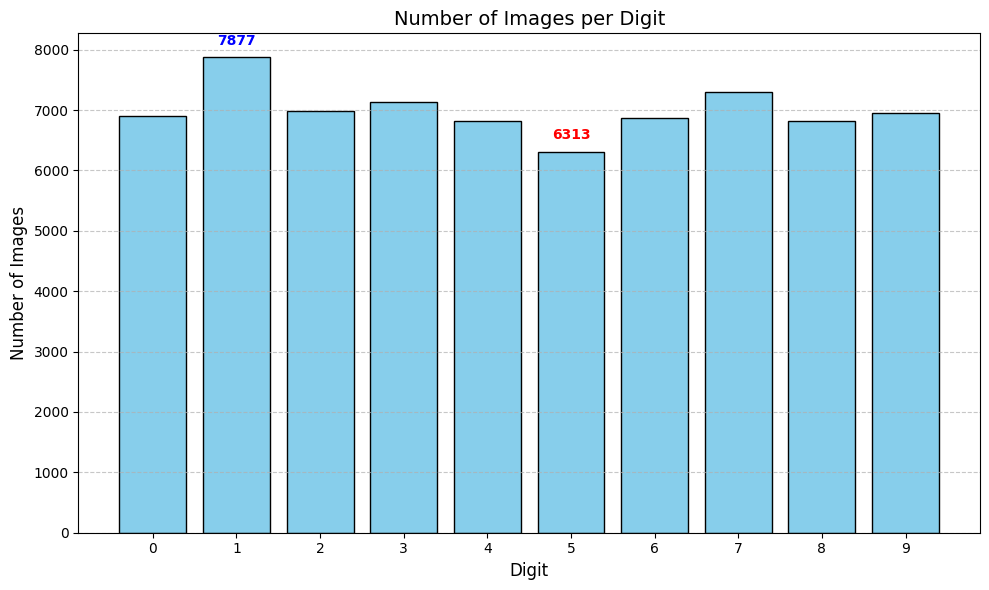

In [86]:
# Corrected way to extract labels from tf.data.Dataset
train_labels_list = [y.numpy() for x, y in ds_train]
test_labels_list = [y.numpy() for x, y in ds_test]

# Convert the lists to a single NumPy array
all_labels = np.array(train_labels_list + test_labels_list)

# Count occurrences of each digit
unique, counts = np.unique(all_labels, return_counts=True)

# Find the highest and lowest counts and their corresponding digits
max_count = np.max(counts)
min_count = np.min(counts)
max_digit = unique[np.argmax(counts)]
min_digit = unique[np.argmin(counts)]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(unique, counts, color="skyblue", edgecolor="black")

# Add text labels for the max and min bars
plt.text(
    max_digit, max_count + 150, f'{max_count}',
    ha='center', va='bottom', fontweight='bold', color='blue'
)
plt.text(
    min_digit, min_count + 150, f'{min_count}',
    ha='center', va='bottom', fontweight='bold', color='red'
)

# Set plot titles and labels
plt.title("Number of Images per Digit", fontsize=14)
plt.xlabel("Digit", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(unique)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

<H3> Preprocessing </H3>

In [87]:
#Preprocessing - Normalization of the the pixel values to (0-255) tf.float 32 (0-1) so that the model can train more effectively. 
def normalize_img(image, label):
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)


#Set up the test dataset the same way as the train dataset
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

<H4> Algorithm Intuition & Model Fitting </H4>

In [88]:
# Build the CNN model
model = models.Sequential()

# First convolutional block
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))

# Second convolutional block
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))

# Third convolutional block
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Add Dense layers for classification
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10)) 

# Print a summary of the model architecture
model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(ds_train, epochs=10, validation_data=ds_test)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 11, 11, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 3, 3, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,642 (256.41 KB)

 Trainable params: 65,642 (256.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.9114 - loss: 0.2815 - val_accuracy: 0.9762 - val_loss: 0.0742
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.9794 - loss: 0.0668 - val_accuracy: 0.9841 - val_loss: 0.0491
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.9862 - loss: 0.0443 - val_accuracy: 0.9901 - val_loss: 0.0314
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.9894 - loss: 0.0340 - val_accuracy: 0.9879 - val_loss: 0.0385
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.9913 - loss: 0.0285 - val_accuracy: 0.9925 - val_loss: 0.0258
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.9928 - loss: 0.0226 - val_accuracy: 0.9883 - val_loss: 0.0395
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.9932 - loss: 0.0204 - val_accuracy: 0.9901 - val_loss: 0.0310
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.9940 - loss: 0.0179 - 

<h1> Results </h1>

26/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

2025-09-16 19:35:24.985652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


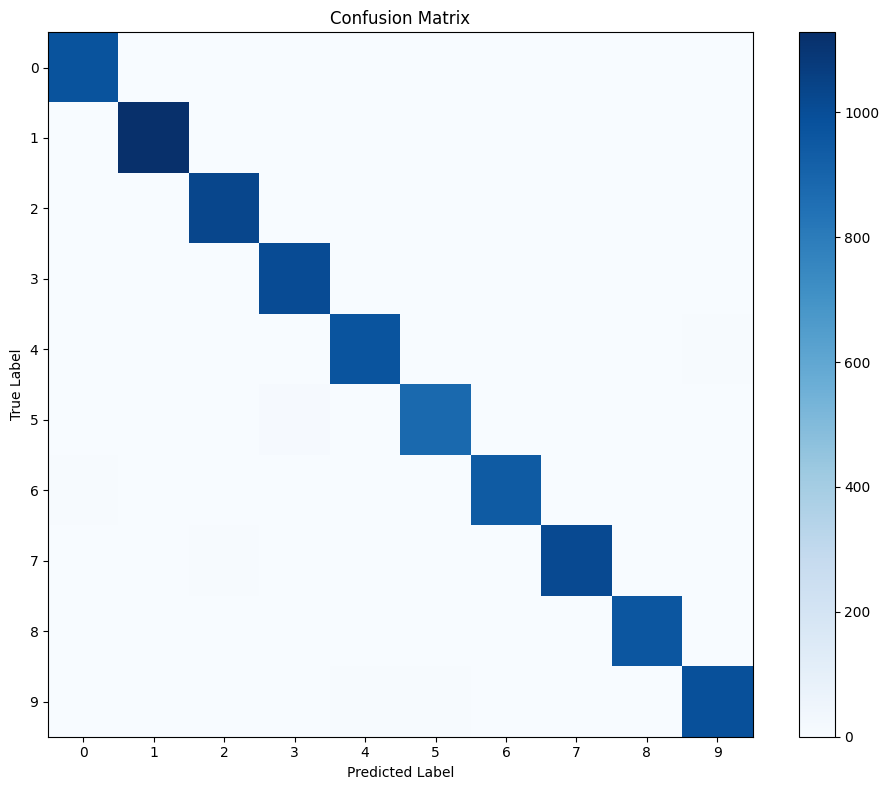


Classification Report:
              precision    recall  f1-score   support

           0     0.9919    0.9959    0.9939       980
           1     0.9956    0.9938    0.9947      1135
           2     0.9866    0.9981    0.9923      1032
           3     0.9786    0.9970    0.9877      1010
           4     0.9939    0.9888    0.9913       982
           5     0.9854    0.9854    0.9854       892
           6     0.9947    0.9802    0.9874       958
           7     0.9922    0.9883    0.9903      1028
           8     0.9908    0.9897    0.9902       974
           9     0.9900    0.9812    0.9856      1009

    accuracy                         0.9900     10000
   macro avg     0.9900    0.9898    0.9899     10000
weighted avg     0.9900    0.9900    0.9900     10000


Overall Accuracy: 0.9900


In [90]:
# True and predicted labels
y_true = np.concatenate([y for x, y in ds_test], axis=0)
y_pred = np.argmax(model.predict(ds_test), axis=1)

# Confusion matrix
cm = tf.math.confusion_matrix(y_true, y_pred)

# Define the class labels for the axes
classes = [str(i) for i in range(10)]

plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap = "Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\nOverall Accuracy: {accuracy:.4f}")
